In [1]:
import sys
sys.path.append(r'C:\Users\festa\OneDrive\Desktop\Thesis\Thesis')
from functions import load_and_process_data, apply_bias_mitigation, evaluate_fairness_metrics, standardize_features, train_classifier_and_find_best_threshold, apply_best_threshold_and_compute_metrics, plot_metrics_dir, plot_metrics_aod, train_classifier_on_transformed_data, extract_fairness_metrics
from functions import evaluate_on_transformed_data_LFR
import numpy as np
from aif360.algorithms.preprocessing import LFR
np.random.seed(1)

pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


In [2]:
train, val, test, privileged_groups, unprivileged_groups = load_and_process_data('meps', use_disparate_impact_remover=False)

In [3]:
# Apply Learning Fair Representations (LFR)
lfr = LFR(unprivileged_groups=unprivileged_groups,
          privileged_groups=privileged_groups,
           k=10, Ax=0.1, Ay=1, Az=1.7, seed=42, 
           verbose=1)
train_transf = lfr.fit_transform(train)
test_transf = lfr.transform(test)

step: 0, loss: 54.39633247201653, L_x: 536.8090716295391,  L_y: 0.7146611134596111,  L_z: 0.00044952682529954063
step: 250, loss: 53.90689677673827, L_x: 533.656006827676,  L_y: 0.5405121134941703,  L_z: 0.0004611649861693386
step: 500, loss: 51.4373090005761, L_x: 506.47011912521714,  L_y: 0.7895426699066076,  L_z: 0.00044377538104355683
step: 750, loss: 15.508252826836044, L_x: 80.53650549575995,  L_y: 7.451993082011022,  L_z: 0.0015348207347211367
step: 1000, loss: 50.874349957235054, L_x: 501.15074036824683,  L_y: 0.7585393806664773,  L_z: 0.00043325867287704494
step: 1250, loss: 24.61473359714998, L_x: 239.20449197543434,  L_y: 0.6940878544257917,  L_z: 0.0001156148122075254
step: 1500, loss: 1.7140956040132818, L_x: 7.530317374884596,  L_y: 0.9485922994882564,  L_z: 0.007336215903862117
step: 1750, loss: 1.656614923749076, L_x: 7.471869295653818,  L_y: 0.8979309379504286,  L_z: 0.006762974254862175
step: 2000, loss: 1.4204125688963403, L_x: 6.935503009244211,  L_y: 0.699071605781

In [4]:
train_before_stat_parity_diff, train_before_disp_impact = evaluate_fairness_metrics(train, unprivileged_groups, privileged_groups, "Train Dataset (Before Transformation)")
test_before_stat_parity_diff, test_before_disp_impact = evaluate_fairness_metrics(test, unprivileged_groups, privileged_groups, "Test Dataset (Before Transformation)")

train_after_stat_parity_diff, train_after_disp_impact = evaluate_fairness_metrics(train_transf, unprivileged_groups, privileged_groups, "Train Dataset (After Transformation)")
test_after_stat_parity_diff, test_after_disp_impact = evaluate_fairness_metrics(test_transf, unprivileged_groups, privileged_groups, "Test Dataset (After Transformation)")

print("Train Dataset (Before Transformation) - Statistical Parity Difference:", train_before_stat_parity_diff)
print("Train Dataset (Before Transformation) - Disparate Impact:", train_before_disp_impact)
print("Test Dataset (Before Transformation) - Statistical Parity Difference:", test_before_stat_parity_diff)
print("Test Dataset (Before Transformation) - Disparate Impact:", test_before_disp_impact)

print("Train Dataset (After Transformation) - Statistical Parity Difference:", train_after_stat_parity_diff)
print("Train Dataset (After Transformation) - Disparate Impact:", train_after_disp_impact)
print("Test Dataset (After Transformation) - Statistical Parity Difference:", test_after_stat_parity_diff)
print("Test Dataset (After Transformation) - Disparate Impact:", test_after_disp_impact)


Train Dataset (Before Transformation) - Statistical Parity Difference: -0.1264
Train Dataset (Before Transformation) - Disparate Impact: 0.5029
Test Dataset (Before Transformation) - Statistical Parity Difference: -0.1491
Test Dataset (Before Transformation) - Disparate Impact: 0.4347
Train Dataset (After Transformation) - Statistical Parity Difference: -0.0236
Train Dataset (After Transformation) - Disparate Impact: 0.6706
Test Dataset (After Transformation) - Statistical Parity Difference: -0.0225
Test Dataset (After Transformation) - Disparate Impact: 0.6553


In [5]:
# Standardize the features (scaling)
train, val, test = standardize_features(train, val, test)

# Choose classifier type
classifier_type = 'random_forest'  # Change to 'random_forest' or 'xgboost'

# Train classifier
classifier, best_threshold, best_balanced_acc = train_classifier_and_find_best_threshold(train, val, classifier_type, unprivileged_groups, privileged_groups)


Best Threshold: 0.18000000000000002
Best Balanced Accuracy: 0.7215607389172584


In [6]:
test_metrics, test_scores = apply_best_threshold_and_compute_metrics(classifier, test, best_threshold, unprivileged_groups, privileged_groups)

Balanced Accuracy (test): 0.7232753164556962
Statistical Parity Difference (test): -0.2361218086193988
Disparate Impact (test): 0.48899901518478595
Average Odds Difference (test): -0.16600275723658975
Equal Opportunity Difference (test): -0.15008646119418168
Theil Index (test): 0.10460378479974483


In [25]:
%matplotlib inline

c:\Users\festa\AppData\Local\Programs\Python\Python312\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)


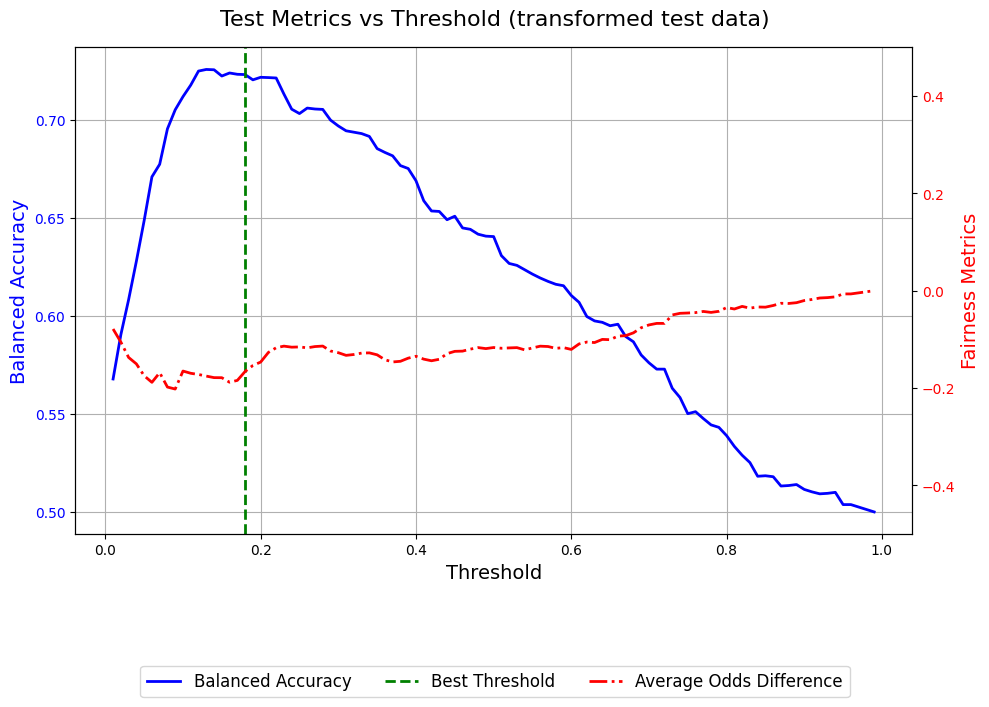

In [7]:
plot_metrics_aod(test, test_scores, best_threshold, unprivileged_groups, privileged_groups)


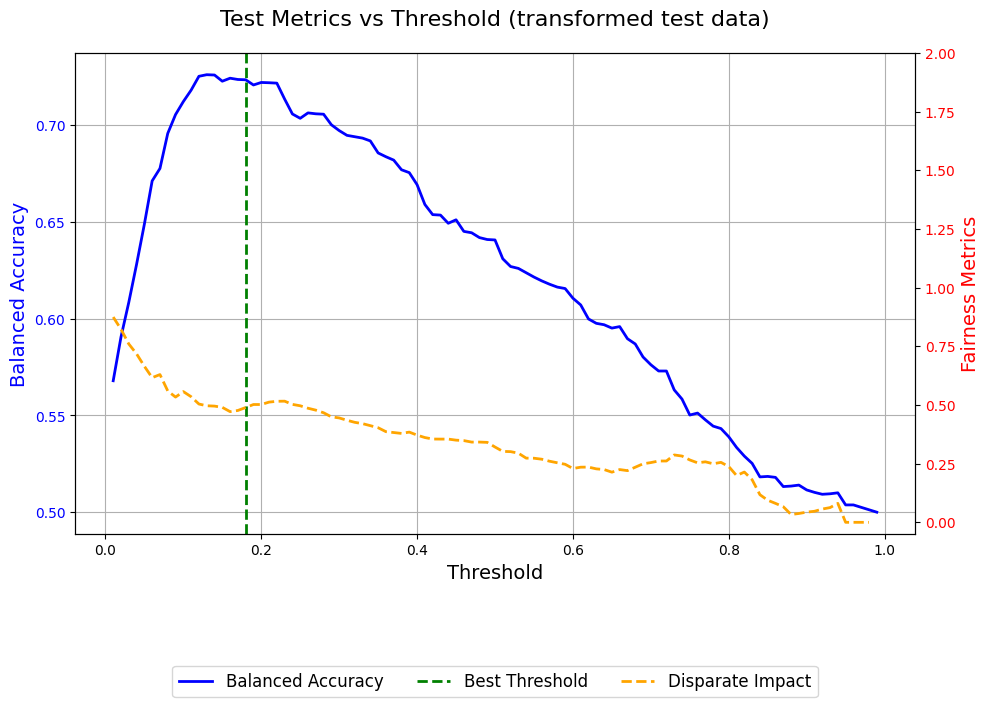

In [8]:
plot_metrics_dir(test, test_scores, best_threshold, unprivileged_groups, privileged_groups)

Unlike other strategies like for example reweighing, where a classifier must be trained to evaluate predictions after adjusting instance weights, LFR generates its own scores as part of its optimization process. These scores are computed to balance reconstruction accuracy, prediction accuracy, and fairness. Since LFR directly provides these fairness-aware scores, there is no need to train a separate classifier on the transformed dataset.

In [9]:
# Standardize the features (scaling)
train_transf, _ , test_transf = standardize_features(train_transf, val, test_transf)
test_transf_scores, test_transf_metrics = evaluate_on_transformed_data_LFR(test, 
    test_transf, best_threshold, unprivileged_groups, privileged_groups)


Balanced Accuracy (test transformed): 0.6842879746835443
Statistical Parity Difference (test transformed): -0.07413488545851188
Disparate Impact (test transformed): 0.7556400121617513
Average Odds Difference (test transformed): -0.02351118341475346
Equal Opportunity Difference (test transformed): -0.029244227443800175
Theil Index (test transformed): 0.12160176553663254


In [28]:
%matplotlib inline

c:\Users\festa\AppData\Local\Programs\Python\Python312\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)


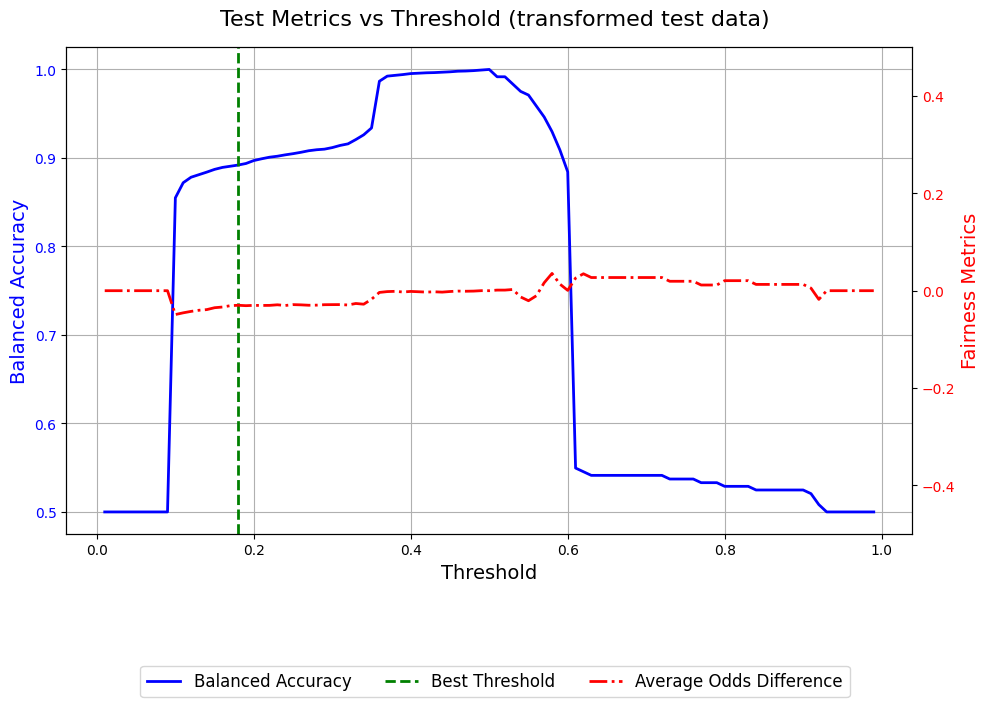

In [10]:
plot_metrics_aod(test_transf, test_transf_scores, best_threshold, unprivileged_groups, privileged_groups)

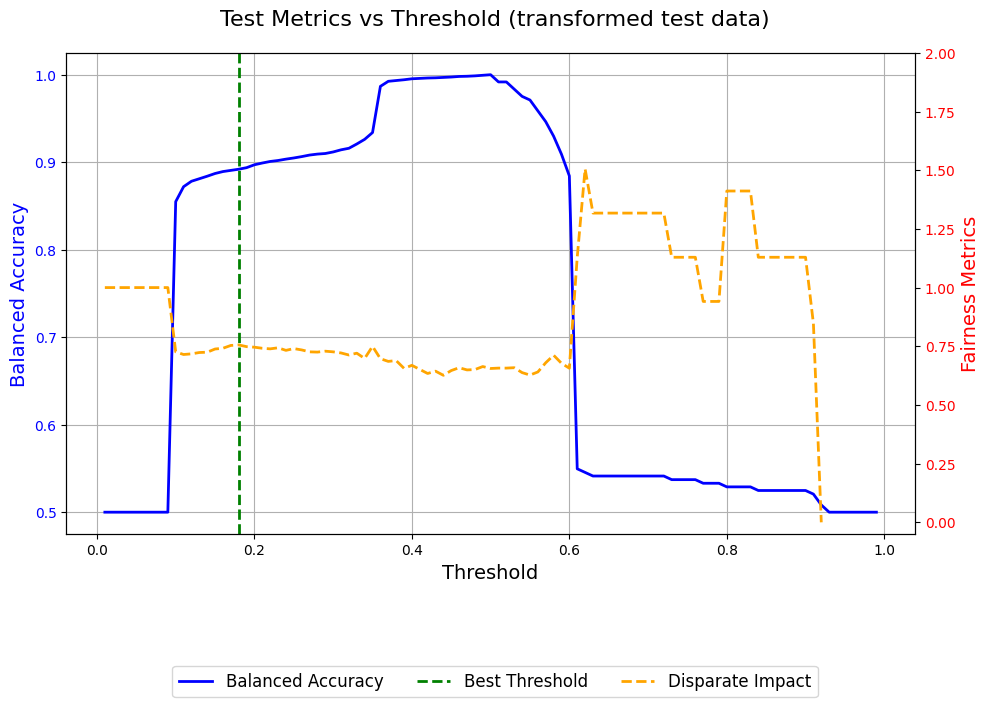

In [11]:
plot_metrics_dir(test_transf, test_transf_scores, best_threshold, unprivileged_groups, privileged_groups)

In [12]:
fairness_metrics, validation_metrics, test_metrics = extract_fairness_metrics(
    train_before_stat_parity_diff, train_after_stat_parity_diff,
    test_before_stat_parity_diff, test_after_stat_parity_diff,
    train_before_disp_impact, train_after_disp_impact,
    test_before_disp_impact, test_after_disp_impact,
    best_threshold, best_balanced_acc,
    test_metrics, test_transf_metrics
)

# Displaying the tables
for table in [fairness_metrics, validation_metrics, test_metrics]:
    display(table.name)
    display(table)


'Fairness Metrics Before and After Transformation'

,Dataset,Stage,Metric,Value
0,Train,Before Transformation,Statistical Parity Difference,-0.1264
1,Train,After Transformation,Statistical Parity Difference,-0.0236
2,Test,Before Transformation,Statistical Parity Difference,-0.1491
3,Test,After Transformation,Statistical Parity Difference,-0.0225
4,Train,Before Transformation,Disparate Impact,0.5029
5,Train,After Transformation,Disparate Impact,0.6706
6,Test,Before Transformation,Disparate Impact,0.4347
7,Test,After Transformation,Disparate Impact,0.6553


'Validation Metrics for Threshold Selection'

,Dataset,Stage,Metric,Value
0,Validation,Best Threshold (Validation),Threshold,0.180000
1,Validation,Best Threshold (Validation),Balanced Accuracy,0.721561


'Test Metrics After Applying Threshold On Original and Transformed'

,Dataset,Stage,Metric,Value
0,Test (Original),After Threshold,Balanced Accuracy,0.723275
1,Test (Transformed),After Threshold,Balanced Accuracy,0.684288
2,Test (Original),After Threshold,Statistical Parity Difference,-0.236122
3,Test (Transformed),After Threshold,Statistical Parity Difference,-0.074135
4,Test (Original),After Threshold,Disparate Impact,0.488999
5,Test (Transformed),After Threshold,Disparate Impact,0.755640
6,Test (Original),After Threshold,Average Odds Difference,-0.166003
7,Test (Transformed),After Threshold,Average Odds Difference,-0.023511
8,Test (Original),After Threshold,Equal Opportunity Difference,-0.150086
9,Test (Transformed),After Threshold,Equal Opportunity Difference,-0.029244
